In [263]:
# Import Functional Libraries
import numpy as np
import pandas as pd

# Import PyTorch
import torch
import torch.nn as nn

# Import Visualization Tools
import matplotlib.pyplot as plt
%matplotlib inline

In [264]:
"""
NOTE: The csv was too large to store in my repo so refer to the first link to download 
NYCTaxiFares.csv and add to empty data folder when testing my code
"""

#data was given from https://www.kaggle.com/datasets/tanyildizderya/nyctaxifares
#which uses data from https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction
#but adds a classification result column that we will use later

df = pd.read_csv('./data/NYCTaxiFares.csv')

df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [265]:
# Fare amount is the column we want to predict with our model
df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [266]:
# The latitude and longitude variables are too similar when traveling inter-city
# We will use the haversine formula to convert coordinates to Euclidean distance
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [267]:
# Calculate haversine distance for train and test datasets
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [268]:
""" 
We choose to embed Hour, Month, and Weekday here so we can treat these values as continuous. 
This allows us to see relations between categorical data as well as update their parameters.
"""
# Add considerable datetime metrics to df
df['EDTdate'] = pd.to_datetime(df['pickup_datetime']).dt.tz_convert('America/New_York')
df['Hour'] = df['EDTdate'].dt.hour
df['Month'] = df['EDTdate'].dt.strftime("%B")
df['Weekday'] = df['EDTdate'].dt.strftime("%A")

df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,Month,Weekday
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56-04:00,4,April,Monday
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53-04:00,11,April,Saturday
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26-04:00,7,April,Saturday
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03-04:00,17,April,Sunday
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01-04:00,22,April,Friday


In [269]:
# Define categorical, numerical, and result columns
category_cols = ['Hour', 'Month', 'Weekday']
num_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
y_col = ['fare_amount']

# Categorify category_cols
cat_stack_train = []
for cat in category_cols:
    df[cat] = df[cat].astype('category')
    cat_stack_train.append(df[cat].cat.codes.values)

# Create numpy array of categorical data
cat_train = np.stack(cat_stack_train, 1)

# Convert arrays to tensors
cat_train = torch.tensor(cat_train, dtype=torch.int64)

# Convert continuous variables to a tensor
cont_train = np.stack([df[col].values for col in num_cols], 1)
cont_train = torch.tensor(cont_train, dtype=torch.float)

# Convert result column to a tensor (there is no result column in testing set)
y = torch.tensor(df[y_col].values, dtype=torch.float).reshape(-1,1)


In [270]:
# This will set embedding sizes for Hours, Months, and Weekdays
# Embedding size determination: half the number of unique categories, 50 max
cat_szs = [len(df[col].cat.categories) for col in category_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (1, 1), (7, 4)]

In [271]:
# Define Model
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [272]:
# Instantiate model
torch.manual_seed(42)
model = TabularModel(emb_szs, cont_train.shape[1], 1, [200,100], p=0.4)

In [273]:
# Define loss and optimizer functions
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [274]:
# This cell allows you to batch the data if desired, but I will be using the entite dataset
batch_size = 120000
test_size = int(batch_size * .2)

ca_train = cat_train[:batch_size-test_size]
ca_test = cat_train[batch_size-test_size:batch_size]
con_train = cont_train[:batch_size-test_size]
con_test = cont_train[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [275]:
# Train model
import time
start_time = time.time()

epochs = 301
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(ca_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss.detach())
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.62602520
epoch:  26  loss: 10.92976952
epoch:  51  loss: 10.26382732
epoch:  76  loss: 9.75613308
epoch: 101  loss: 9.19593430
epoch: 126  loss: 8.41846085
epoch: 151  loss: 7.41217899
epoch: 176  loss: 6.24153566
epoch: 201  loss: 5.06508780
epoch: 226  loss: 4.20178223
epoch: 251  loss: 3.83894253
epoch: 276  loss: 3.73516726
epoch: 301  loss: 3.67330480
epoch: 301  loss: 3.67330480

Duration: 148 seconds


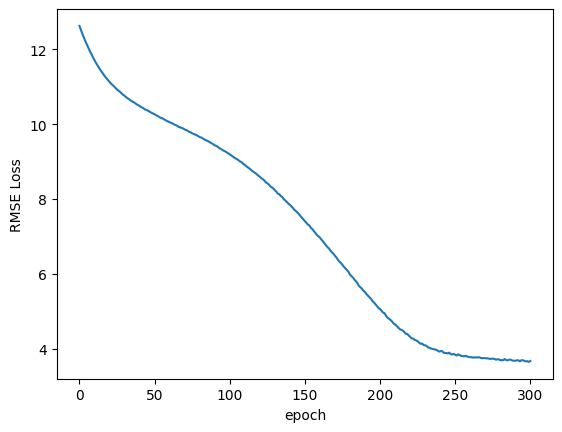

In [276]:
# Plot loss over epoch
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [277]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(ca_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.73214340


In [278]:
# Sample some predictions and difference from actual
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(50):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.  10.8624   8.1000   2.7624
 2.   8.9992  12.1000   3.1008
 3.   7.0419   4.9000   2.1419
 4.  19.8395  15.3000   4.5395
 5.  11.6067  11.3000   0.3067
 6.  21.4957  16.5000   4.9957
 7.   5.9839   3.3000   2.6839
 8.   4.7454   4.5000   0.2454
 9.   6.8146   5.7000   1.1146
10.  24.9453  20.1000   4.8453
11.   5.5579   8.9000   3.3421
12.   6.2773   7.7000   1.4227
13.   4.7703   5.7000   0.9297
14.   4.2882   4.5000   0.2118
15.   9.5545   9.3000   0.2545
16.  12.6207   4.9000   7.7207
17.  15.9216  12.1000   3.8216
18.   6.5509   6.9000   0.3491
19.   6.7360  11.3000   4.5640
20.   1.9740   6.5000   4.5260
21.   7.5430   5.3000   2.2430
22.   5.7750   5.3000   0.4750
23.  17.0113  20.1000   3.0887
24.  11.2059  14.9000   3.6941
25.   5.9632   8.9000   2.9368
26.  13.5049   8.5000   5.0049
27.   4.4666   4.5000   0.0334
28.  19.7215  18.1000   1.6215
29.   6.3460   5.3000   1.0460
30.   9.9482   7.3000   2.6482
31.   5.0027   3.7000   1.3027
32.   5.

In [279]:
# Save trained model to file
# Using model.state_dict() since model is still defined, would use model.save(model, PATH) otherwise
torch.save(model.state_dict(), 'NYCTaxiFares.pt')

In [ ]:
#TODO: Add ability to load model

In [ ]:
#TODO: Add ability to input sample data into model for single point predictions